# Data Preprocessing

## Import Data and Overview

In [1]:
import pandas as pd

full_data = pd.read_csv('data.csv')

In [2]:
pd.set_option('display.max_columns', 0)
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Data Cleaning

### Drop<br>Dummy columns: ['name', 'email', 'phone-number', 'credit_card']<br>Redundant columns: ['arrival_date_week_number', 'reseravation_status']<br>Irrelevant Columns: ['reservation_status_date']<br>Majority Missing Values Columns: ['company']

In [4]:
clean_data = full_data.drop(['name', 'email', 'phone-number', 'credit_card', 'arrival_date_week_number', 'reservation_status_date','reservation_status', 'company'], axis=1)

### Check for NaN values

In [5]:
clean_data.isna().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                             488
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             16340
days_in_waiting_list                  0
customer_type                         0


### Fill in missing values with probable/appropriate values

In [6]:
clean_data['children'].fillna(value=0, inplace=True)
clean_data['country'].fillna(value='COUNTRY_UNKNOWN', inplace=True)
clean_data['agent'].fillna(value=0, inplace=True)

In [7]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_day_of_month       119390 non-null  int64  
 6   stays_in_weekend_nights         119390 non-null  int64  
 7   stays_in_week_nights            119390 non-null  int64  
 8   adults                          119390 non-null  int64  
 9   children                        119390 non-null  float64
 10  babies                          119390 non-null  int64  
 11  meal                            119390 non-null  object 
 12  country         

## Data Transformation

### Make a copy

In [8]:
data = clean_data.copy()

### Convert month name to month number

In [9]:
month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,}
data.arrival_date_month = data.arrival_date_month.map(month_map)

### Convert other categorical variables into numeric variables and map it using a dataframe

In [10]:
cat_list = [column for column in data.columns if data[column].dtype == 'object']
cat_map = pd.DataFrame(columns=['variable', 'old_val', 'new_val'])

for cat in cat_list:
    cat_val = pd.Series(data[cat].unique())
    for _val in range(len(cat_val)):
        cat_dict = pd.Series({'variable' : cat, 'old_val' : cat_val[_val], 'new_val' : _val})
        cat_map = pd.concat([cat_map, cat_dict.to_frame().T], ignore_index=True)
        data[cat] = data[cat].replace(cat_val[_val], _val)
        
cat_map.set_index(['variable', 'new_val'], inplace=True)
cat_map.loc["hotel"]        

,old_val
new_val,
0,Resort Hotel
1,City Hotel


### Print Processed DataFrame

In [11]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,0,342,2015,7,1,0,0,2,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0.0,0,0,0.0,0,0
1,0,0,737,2015,7,1,0,0,2,0.0,0,0,0,0,0,0,0,0,0,0,4,0,0.0,0,0,0.0,0,0
2,0,0,7,2015,7,1,0,1,1,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0.0,0,0,75.0,0,0
3,0,0,13,2015,7,1,0,1,1,0.0,0,0,1,1,1,0,0,0,1,1,0,0,304.0,0,0,75.0,0,0
4,0,0,14,2015,7,1,0,2,2,0.0,0,0,1,2,2,0,0,0,1,1,0,0,240.0,0,0,98.0,0,1


## Split data to X and Y

In [12]:
X_init = data.drop(['is_canceled'], axis=1)
Y_init = data['is_canceled']

In [13]:
Y_init.value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [14]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()
X, Y = nm.fit_resample(X_init, Y_init)
X.shape, Y.shape

((88448, 27), (88448,))

## Scale Predictor Variables

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

SS = StandardScaler()
X_std = SS.fit_transform(X)

MMS = MinMaxScaler()
X_mm = MMS.fit_transform(X)

# Data Visualization

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

## reservation_status - Pie Chart

In [17]:
type(clean_data['is_canceled'].value_counts())

pandas.core.series.Series

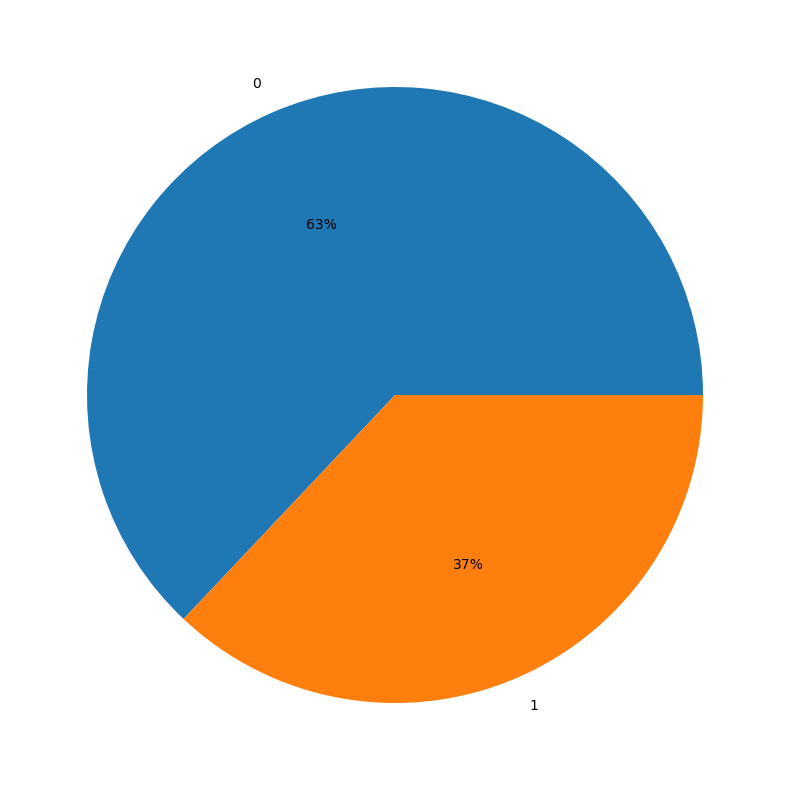

In [18]:
plt.figure(figsize=(10,10))
res_st_data = clean_data['is_canceled'].value_counts().values
res_label = clean_data['is_canceled'].value_counts().index
plt.pie(res_st_data, labels=res_label, autopct='%1.0f%%')
plt.show()

## 'reservation_status' per 'hotel'

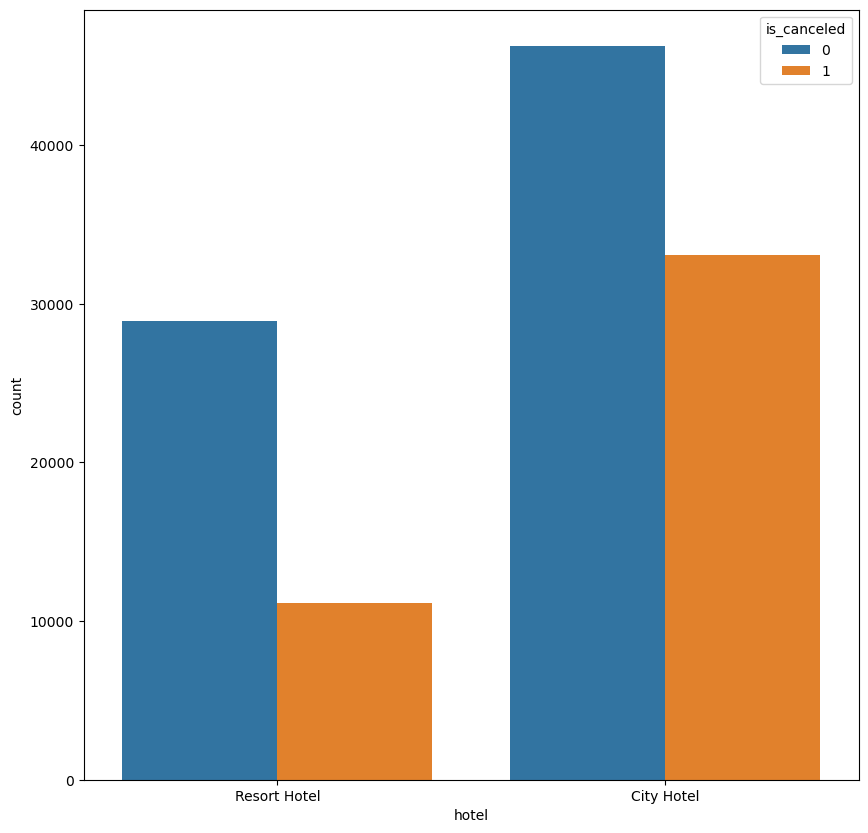

In [19]:
plt.figure(figsize=(10,10))
sns.countplot(x = clean_data['hotel'], hue=clean_data['is_canceled'])
plt.show()

## 'reservation_status' vs 'lead_time'

<Figure size 1000x1000 with 0 Axes>

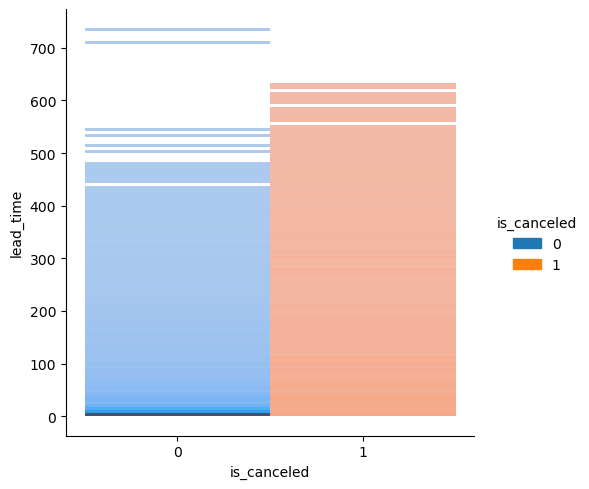

In [20]:
plt.figure(figsize=(10,10))
sns.displot(x = clean_data['is_canceled'].astype(str), y = clean_data['lead_time'], hue=clean_data['is_canceled'].astype(str))
plt.show()

## 'reservation_status' per 'arrival_date_month'

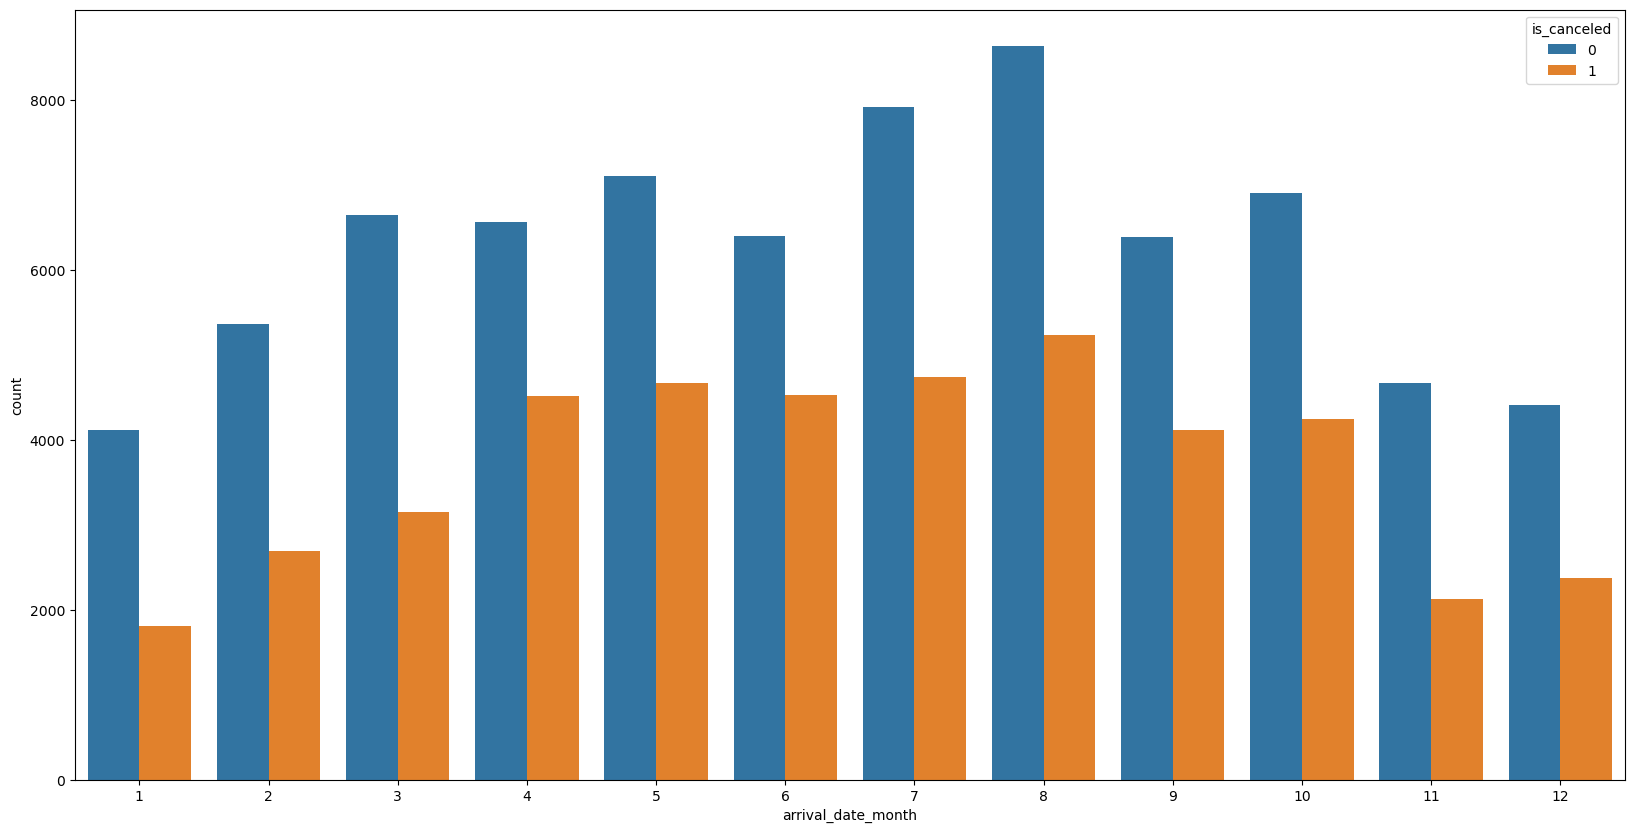

In [21]:
month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,}

plt.figure(figsize=(20,10))
sns.countplot(x=clean_data['arrival_date_month'].map(month_map), hue=clean_data['is_canceled'])
plt.show()

## 'reservation_status' per 'customer_type'

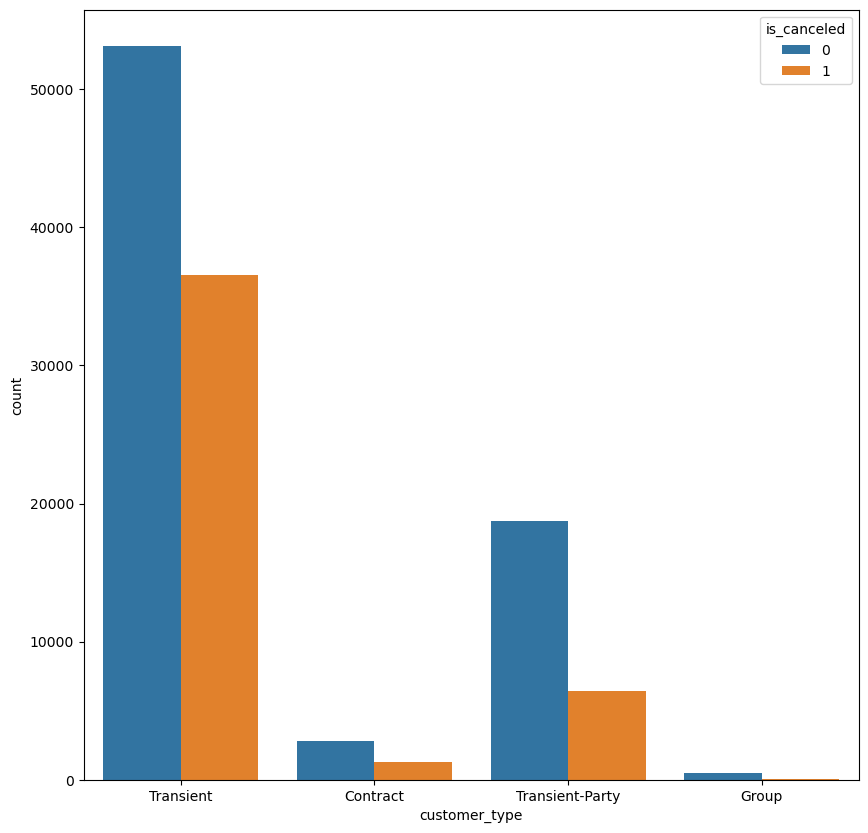

In [22]:
plt.figure(figsize=(10,10))
sns.countplot(x = clean_data['customer_type'], hue = clean_data['is_canceled'])
plt.show()

## 'reservation_status' per 'market_segment'

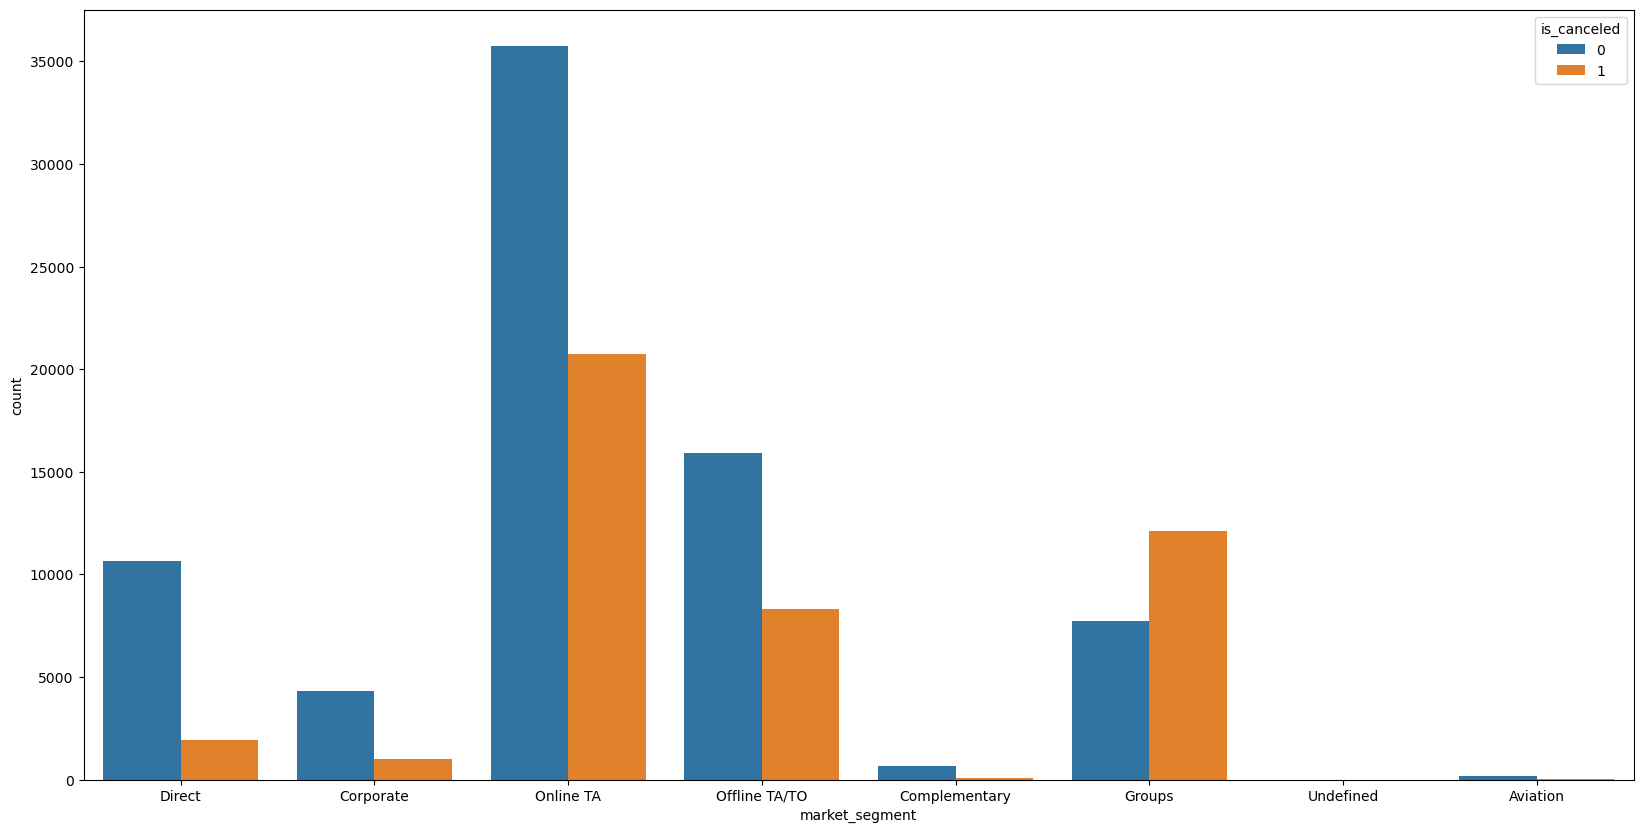

In [23]:
plt.figure(figsize=(20,10))
sns.countplot(x = clean_data['market_segment'], hue = clean_data['is_canceled'])
plt.show()

## 'reserved_room_obtained' per 'arrival_date_month'

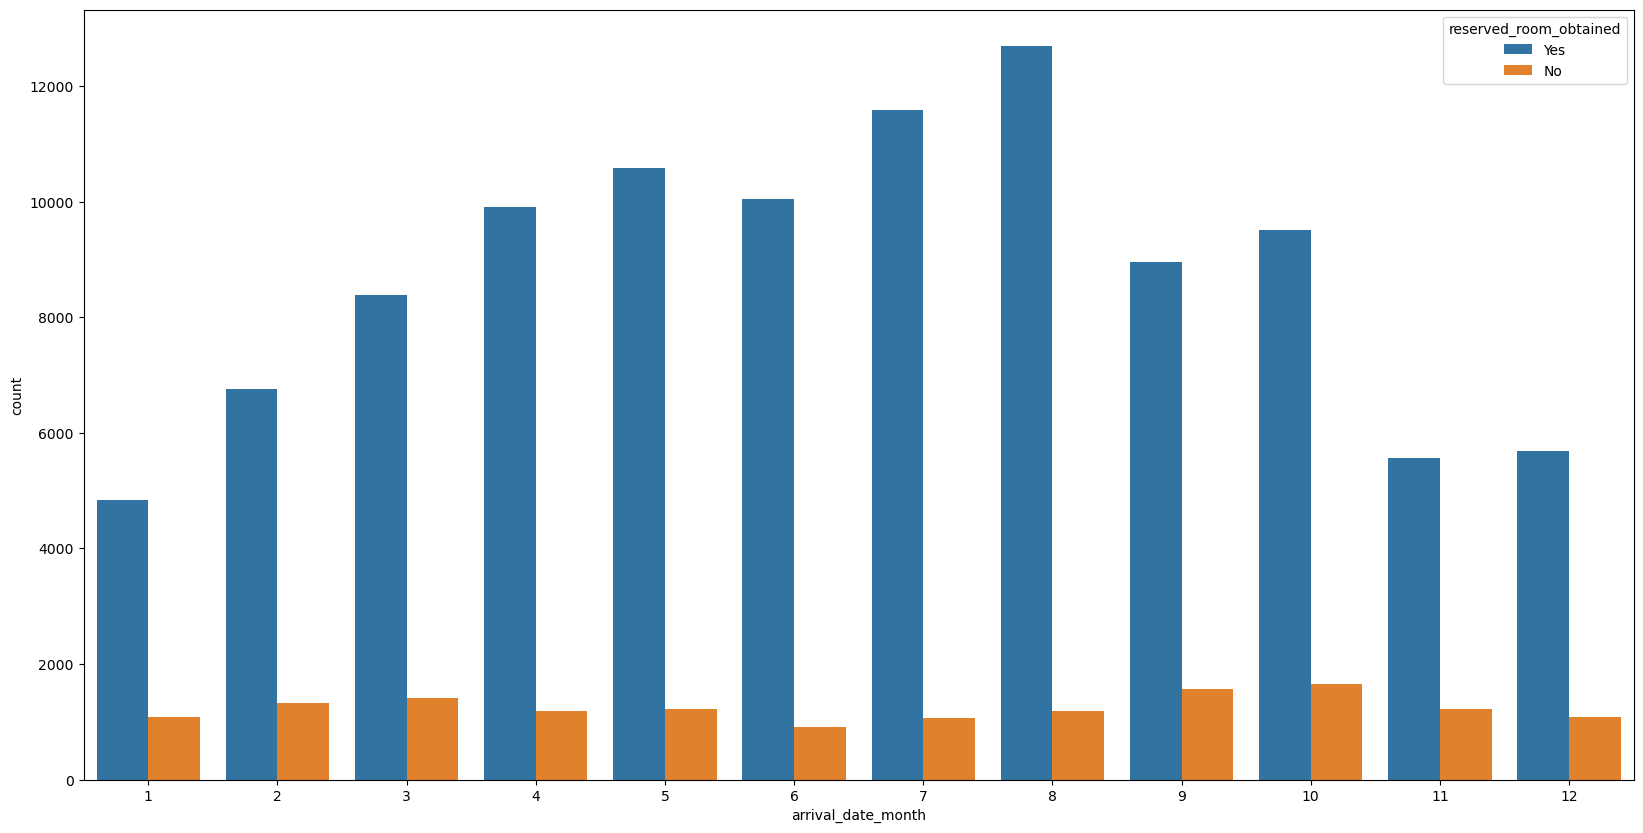

In [24]:
import numpy as np

clean_data['reserved_room_obtained'] = np.where(clean_data['reserved_room_type'] == clean_data['assigned_room_type'], 'Yes','No')
month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,}

plt.figure(figsize=(20,10))
sns.countplot(x=clean_data['arrival_date_month'].map(month_map), hue=clean_data['reserved_room_obtained'])
plt.show()

# Classification Model Comparison

## Split data using train_test_split

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size = 0.2)

## Fit and Predict using various sklearn.ensemble techniques

In [26]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

algo_list = [RandomForestClassifier(),
             ExtraTreesClassifier(),
             AdaBoostClassifier(),
             HistGradientBoostingClassifier(),
             GradientBoostingClassifier()]
reports = {}
score_list = []
for algo in algo_list:
    model = algo
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    score_list.append(model.score(X_test, Y_test) * 100)
    reports[str(algo)] = classification_report(Y_test, Y_pred)

In [27]:
print(reports['AdaBoostClassifier()'])

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      8853
           1       0.83      0.79      0.81      8837

    accuracy                           0.81     17690
   macro avg       0.82      0.81      0.81     17690
weighted avg       0.82      0.81      0.81     17690



In [28]:
print(reports['ExtraTreesClassifier()'])

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8853
           1       0.89      0.86      0.87      8837

    accuracy                           0.88     17690
   macro avg       0.88      0.88      0.88     17690
weighted avg       0.88      0.88      0.88     17690



In [29]:
print(reports['GradientBoostingClassifier()'])

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      8853
           1       0.85      0.81      0.83      8837

    accuracy                           0.83     17690
   macro avg       0.83      0.83      0.83     17690
weighted avg       0.83      0.83      0.83     17690



In [30]:
print(reports['HistGradientBoostingClassifier()'])

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      8853
           1       0.87      0.84      0.86      8837

    accuracy                           0.86     17690
   macro avg       0.86      0.86      0.86     17690
weighted avg       0.86      0.86      0.86     17690



In [31]:
print(reports['RandomForestClassifier()'])

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      8853
           1       0.89      0.87      0.88      8837

    accuracy                           0.88     17690
   macro avg       0.88      0.88      0.88     17690
weighted avg       0.88      0.88      0.88     17690



## Model Accuracy Comparison and Visualization

In [32]:
acc_comp = pd.Series(score_list, index=algo_list)
model_names = [str(algo) for algo in algo_list]

acc_df = pd.DataFrame({'Model': model_names, 'Accuracy': score_list})
acc_df.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
0,RandomForestClassifier(),88.258903
1,ExtraTreesClassifier(),87.772753
3,HistGradientBoostingClassifier(),85.890334
4,GradientBoostingClassifier(),83.205201
2,AdaBoostClassifier(),81.469757


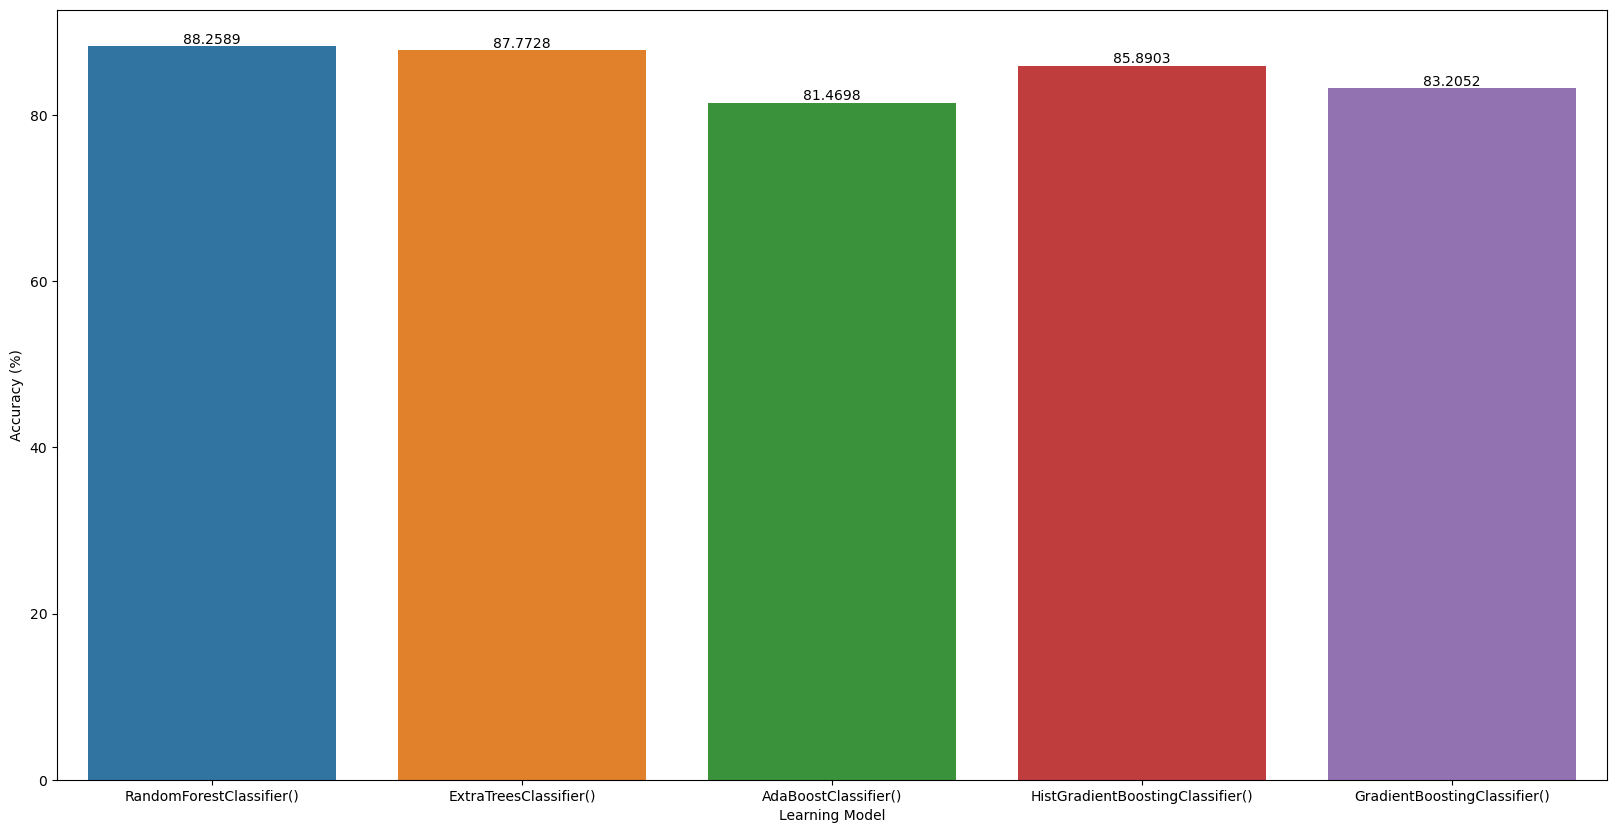

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20,10))
comp_barg = sns.barplot(x = model_names , y= score_list)
comp_barg.set(xlabel="Learning Model", ylabel="Accuracy (%)")
comp_barg.bar_label(comp_barg.containers[0], label_type='edge')
plt.show()

# Feature Selection Methods Comparison

## Selection using SelectKBest(chi2)

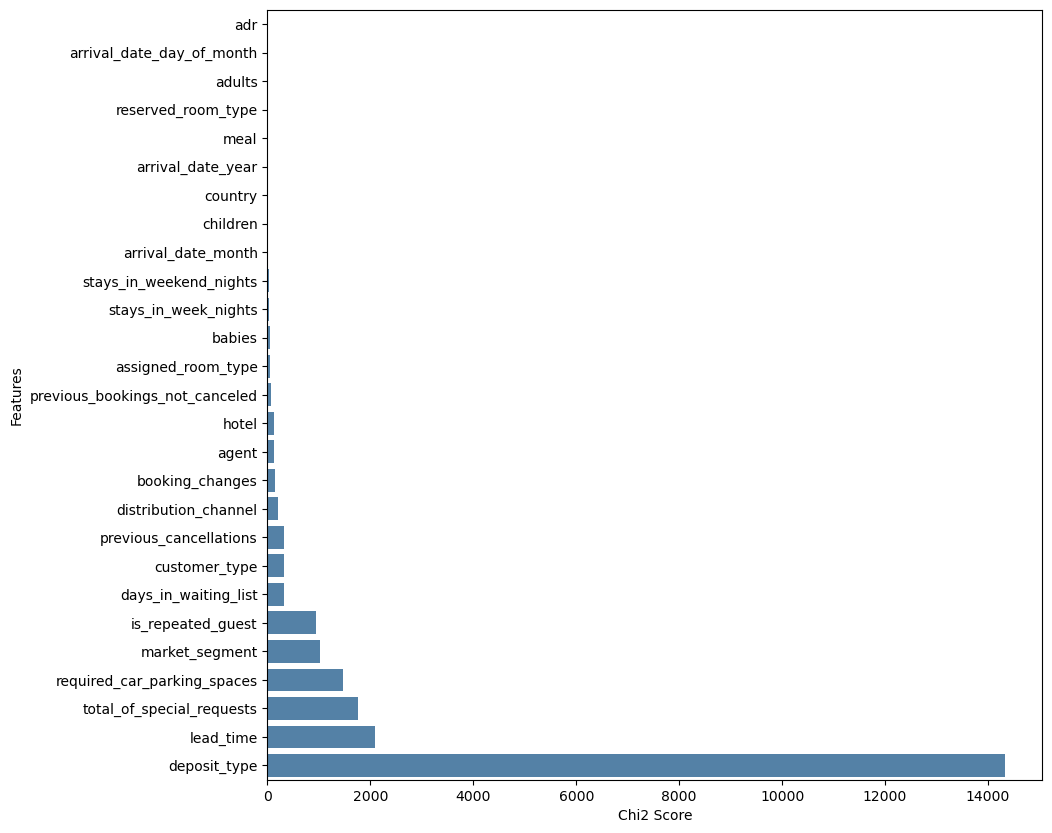

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi2_model = SelectKBest(score_func=chi2, k='all')

chi2_test = chi2_model.fit(X_mm, Y)

chi2_score = pd.Series(chi2_test.scores_, index=X.columns)
chi2_score = chi2_score.sort_values()

plt.figure(figsize=(10,10))

chi2_bar_plot = sns.barplot(x = chi2_score.values, y = chi2_score.index, color='steelblue')
chi2_bar_plot.set(xlabel="Chi2 Score", ylabel="Features")
plt.show()

In [35]:
chi2_score

adr                                   0.630727
arrival_date_day_of_month             1.015354
adults                                1.049346
reserved_room_type                    1.447454
meal                                  4.717597
arrival_date_year                     7.531168
country                               8.646665
children                             14.458837
arrival_date_month                   19.604839
stays_in_weekend_nights              22.741383
stays_in_week_nights                 34.928452
babies                               46.566901
assigned_room_type                   48.021163
previous_bookings_not_canceled       66.150850
hotel                               127.656818
agent                               136.932875
booking_changes                     155.401766
distribution_channel                197.425802
previous_cancellations              314.201220
customer_type                       314.935837
days_in_waiting_list                325.591711
is_repeated_g

In [36]:
feat_len = len(chi2_score)
chi2_df = pd.DataFrame()
while (feat_len >= 1):
    X_imp = X[chi2_score.nlargest(feat_len).index]
    
    SS = StandardScaler()
    X_imp_std = SS.fit_transform(X_imp)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_imp_std,Y, test_size = 0.2)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, Y_train)
    
    rf_acc = rf.score(X_test, Y_test) * 100
    rf_ser = pd.Series({'Feature Length': feat_len, 'Accuracy': rf_acc})
    chi2_df = pd.concat([chi2_df, rf_ser.to_frame().T], ignore_index=True)
    
    feat_len = feat_len - 1

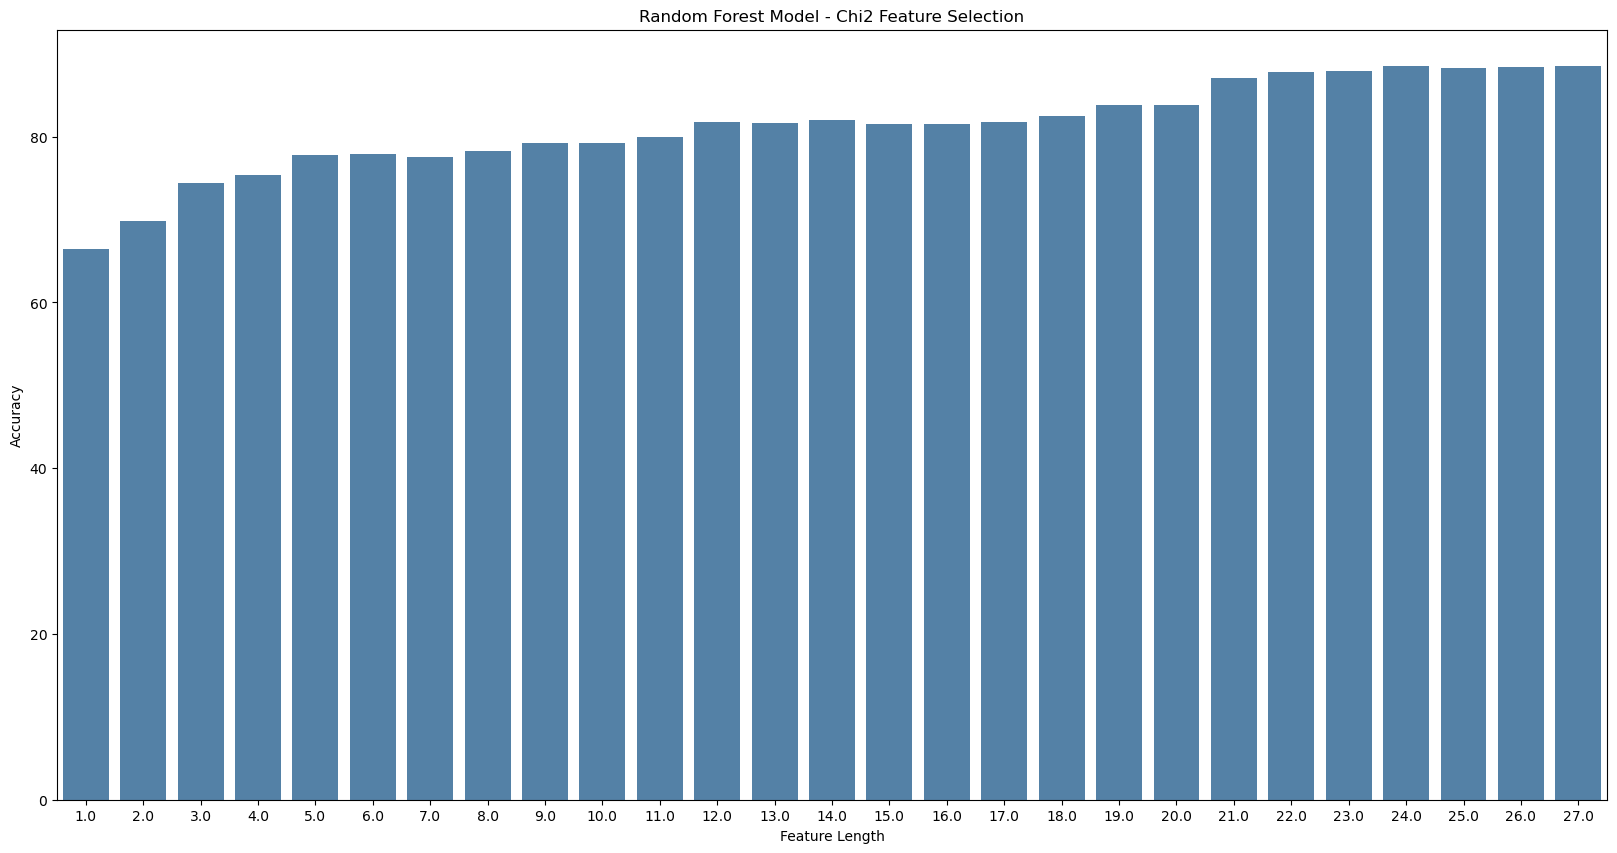

In [37]:
plt.figure(figsize=(20,10)) 
rf_plot = sns.barplot(x=chi2_df['Feature Length'], y=chi2_df['Accuracy'], color='steelblue')
rf_plot.set(title='Random Forest Model - Chi2 Feature Selection')
plt.show()

In [38]:
chi2_df_acc = pd.Series(chi2_df['Accuracy'].describe())
chi2_df_acc

count    27.000000
mean     81.222285
std       5.639490
min      66.500848
25%      78.072357
50%      81.622386
75%      85.480497
max      88.485020
Name: Accuracy, dtype: float64

## Selection Using ExtraTreesClassifier

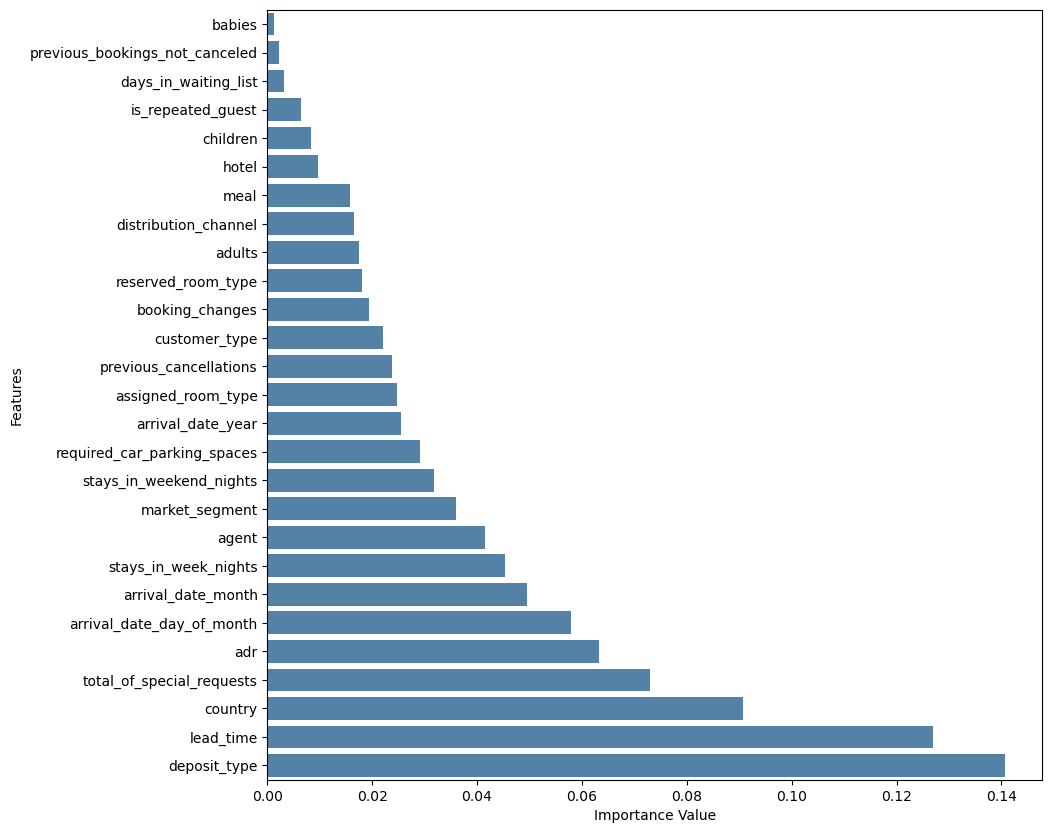

In [39]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_std, Y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values()
plt.figure(figsize=(10,10))
imp_bar_plot = sns.barplot(y = feat_importances.index, x = feat_importances.values, color='steelblue')
imp_bar_plot.set(xlabel="Importance Value", ylabel="Features")

plt.show()

In [40]:
feat_len = len(feat_importances)
ft_imp_df = pd.DataFrame()
while (feat_len >= 1):
    X_imp = X[feat_importances.nlargest(feat_len).index]
    
    SS = StandardScaler()
    X_imp_std = SS.fit_transform(X_imp)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_imp_std,Y, test_size = 0.2)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, Y_train)
    
    rf_acc = rf.score(X_test, Y_test) * 100
    rf_ser = pd.Series({'Feature Length': feat_len, 'Accuracy': rf_acc})
    ft_imp_df = pd.concat([ft_imp_df, rf_ser.to_frame().T], ignore_index=True)
    
    feat_len = feat_len - 1

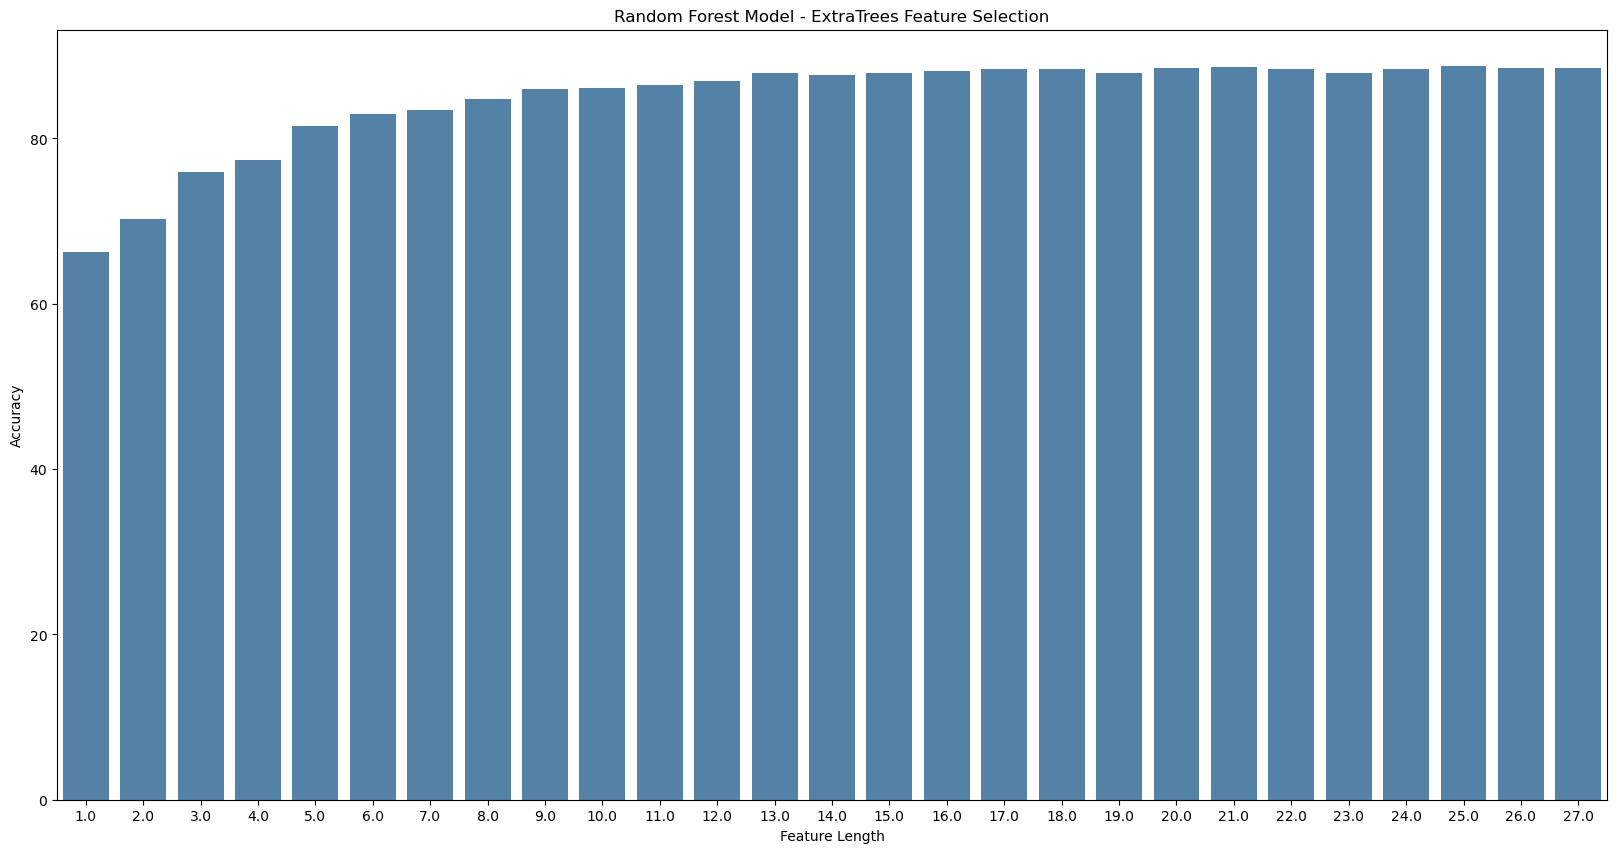

In [41]:
plt.figure(figsize=(20,10)) 
rf_plot = sns.barplot(x=ft_imp_df['Feature Length'], y=ft_imp_df['Accuracy'], color='steelblue')
rf_plot.set(title='Random Forest Model - ExtraTrees Feature Selection')
plt.show()

In [42]:
ft_imp_df_acc = pd.Series(ft_imp_df['Accuracy'].describe())
ft_imp_df_acc

count    27.000000
mean     84.889559
std       5.875784
min      66.252120
25%      84.140757
50%      87.863200
75%      88.388920
max      88.722442
Name: Accuracy, dtype: float64

## Selection Using Correlation Value

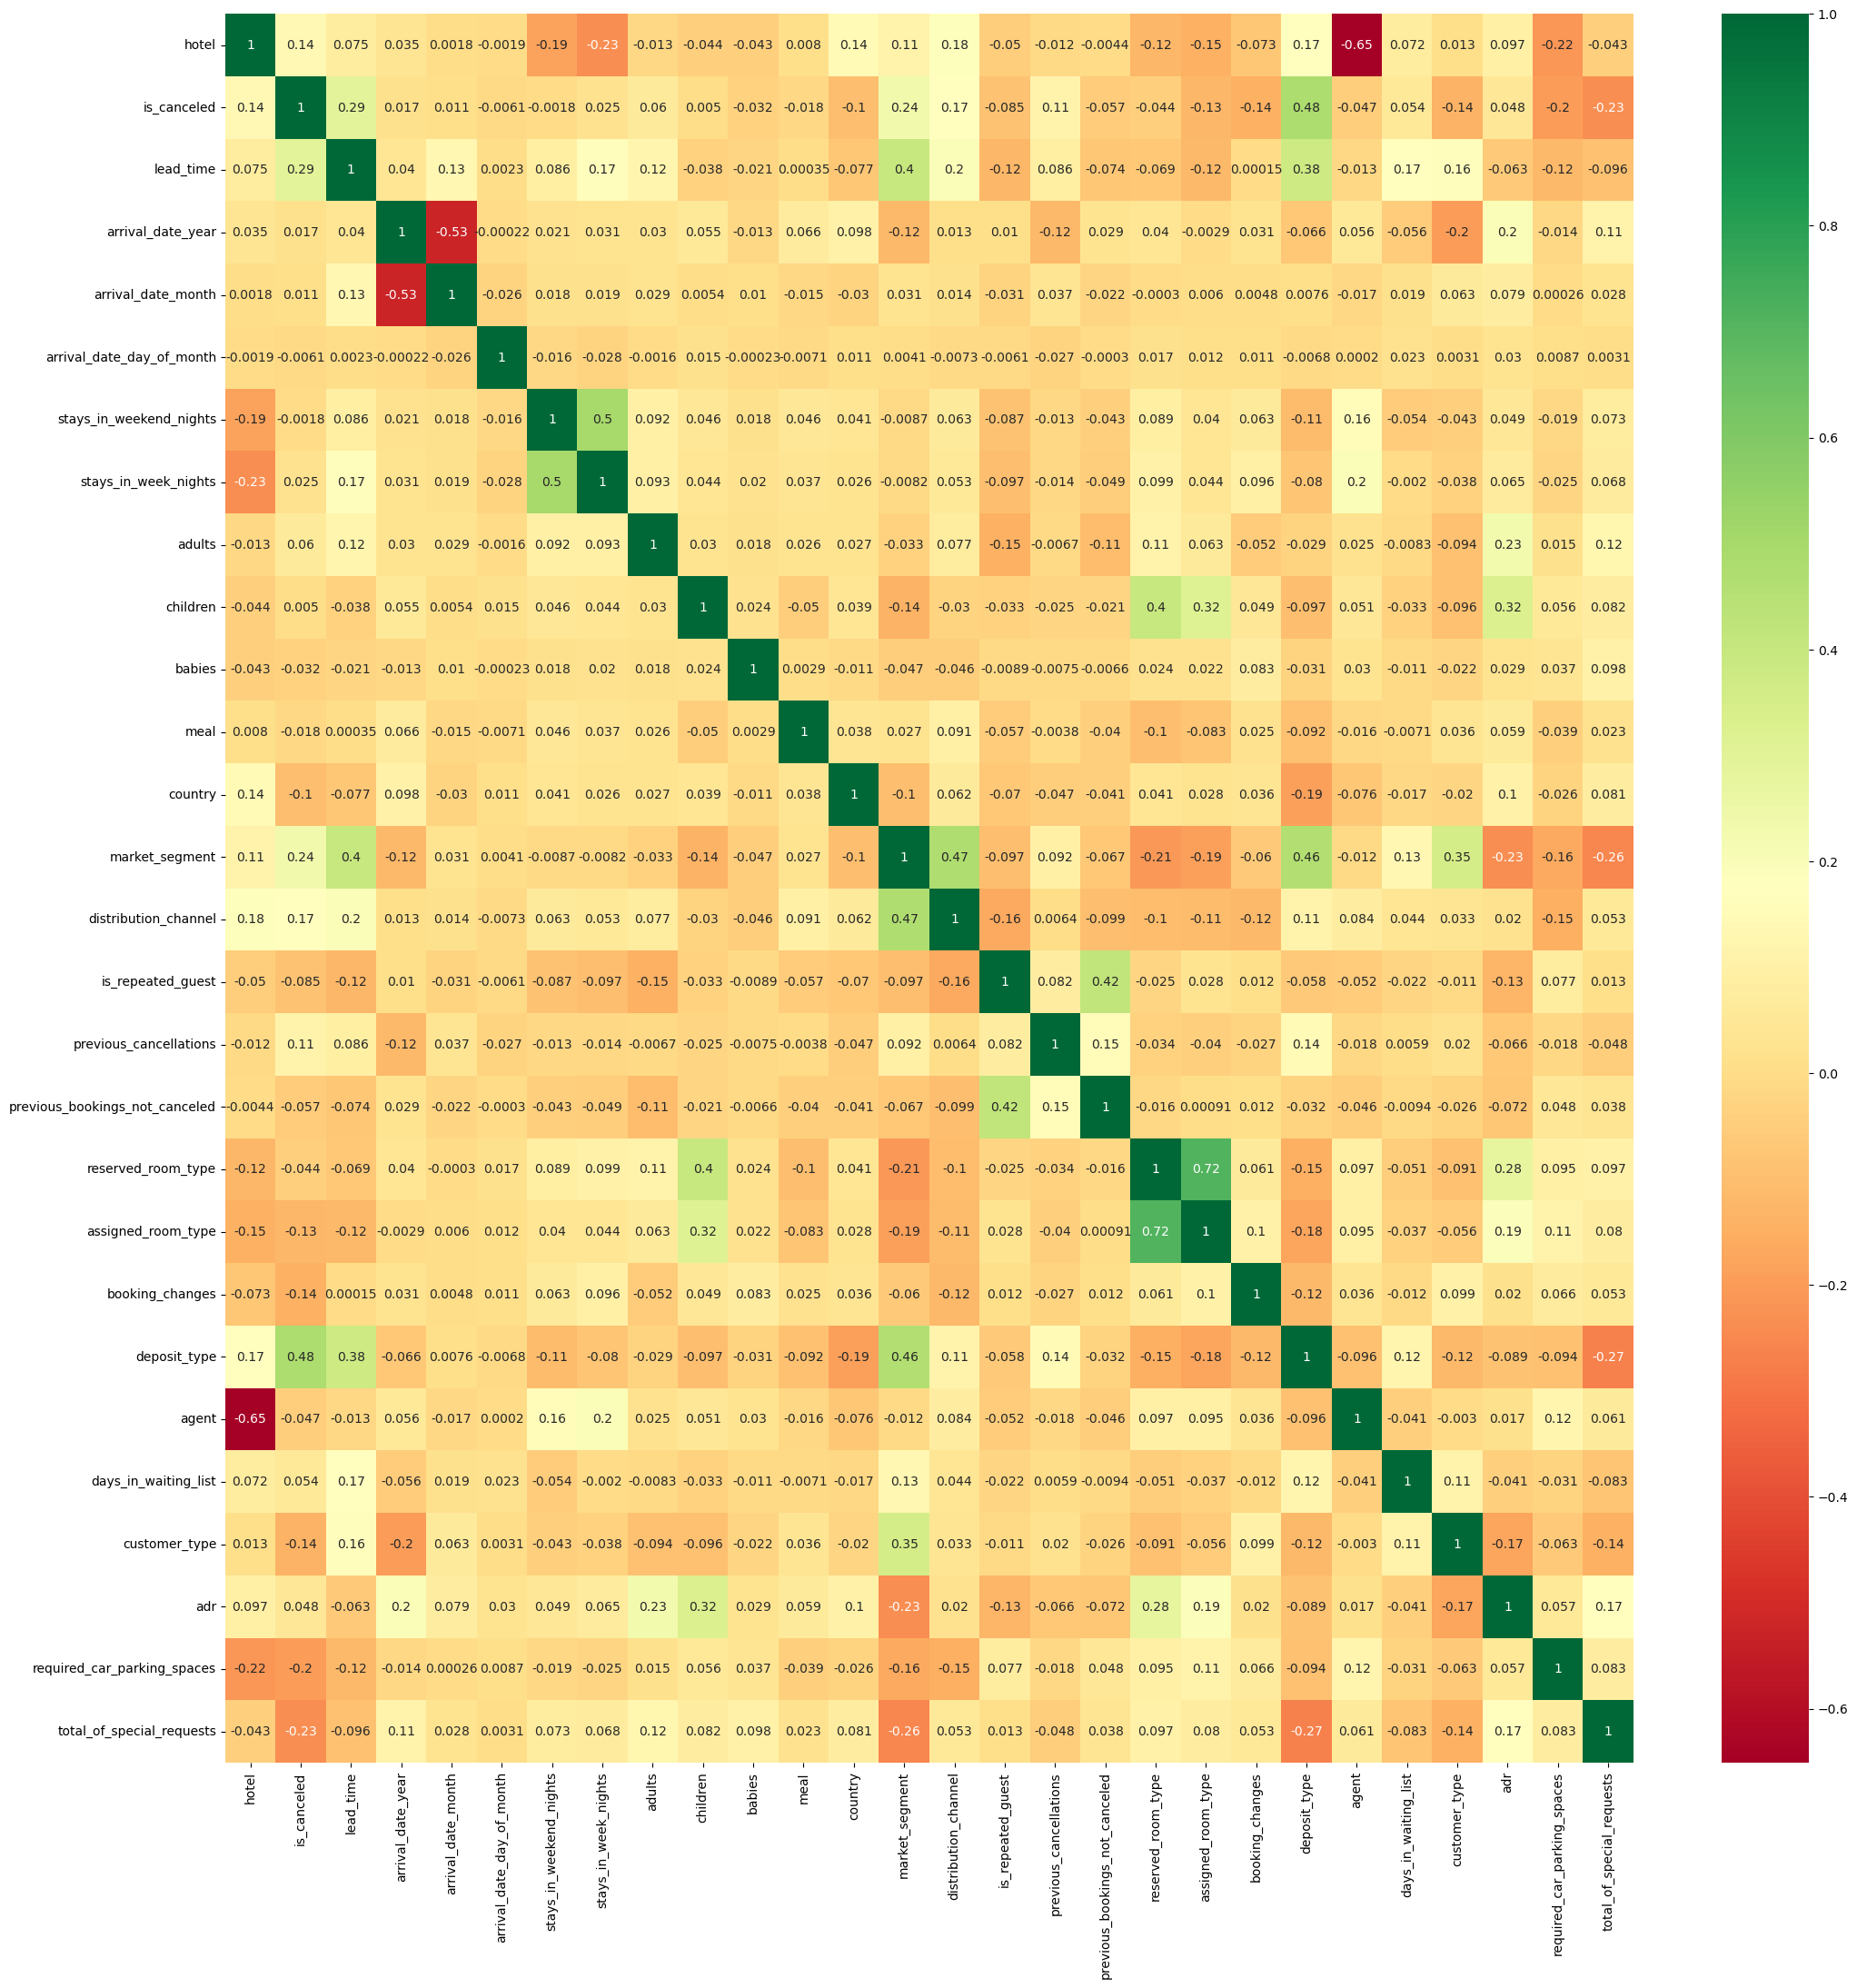

In [43]:
corr_mtx = data.corr()

plt.figure(figsize=(25,25))
hmap = sns.heatmap(corr_mtx, annot=True, cmap="RdYlGn")
plt.show()

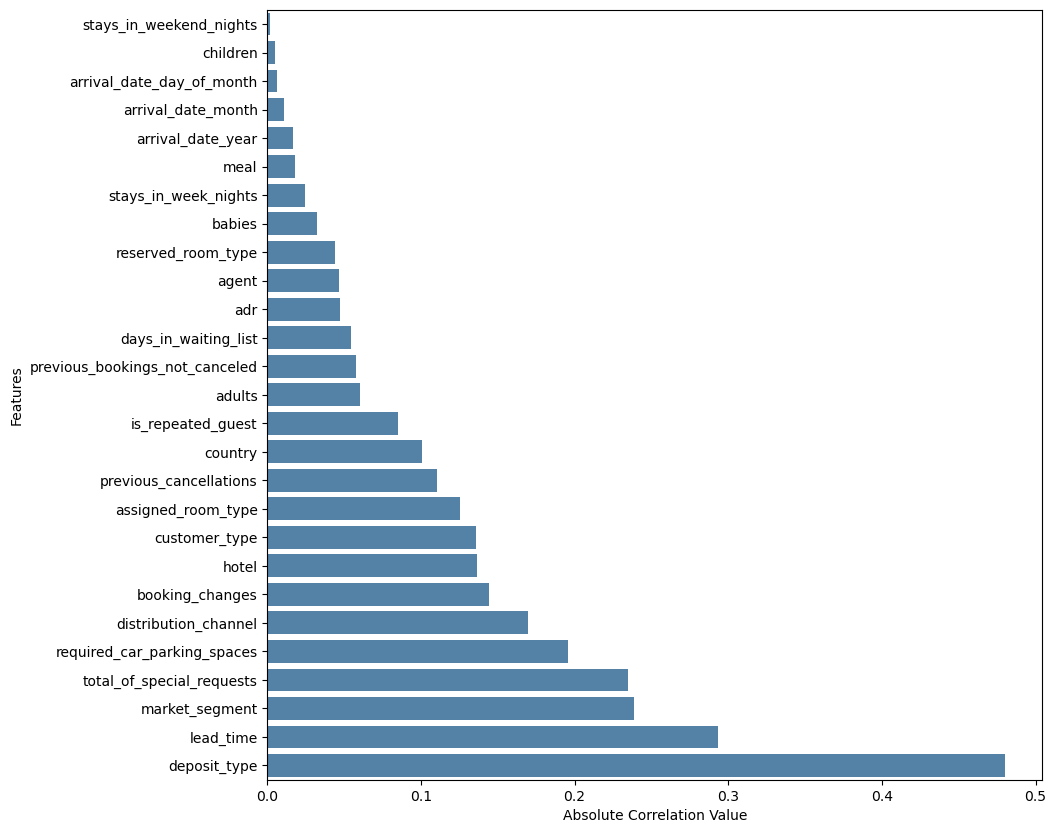

In [44]:
target_corr = corr_mtx['is_canceled'].drop(['is_canceled'], axis=0)
for val in range(len(target_corr)):
    target_corr[val] = abs(target_corr[val])
plt.figure(figsize=(10,10))
target_corr = target_corr.sort_values()
corr_bar_plot = sns.barplot(y = target_corr.index, x = target_corr.values, color='steelblue')
corr_bar_plot.set(xlabel="Absolute Correlation Value", ylabel="Features")
plt.show()

In [45]:
feat_len = len(target_corr)
corr_df = pd.DataFrame()

while (feat_len >= 1):
    X_imp = X[target_corr.nlargest(feat_len).index]
    
    SS = StandardScaler()
    X_imp_std = SS.fit_transform(X_imp)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_imp_std,Y, test_size = 0.2)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, Y_train)
    
    rf_acc = rf.score(X_test, Y_test) * 100
    rf_ser = pd.Series({'Feature Length': feat_len, 'Accuracy': rf_acc})
    corr_df = pd.concat([corr_df, rf_ser.to_frame().T], ignore_index=True)
    
    feat_len = feat_len - 1

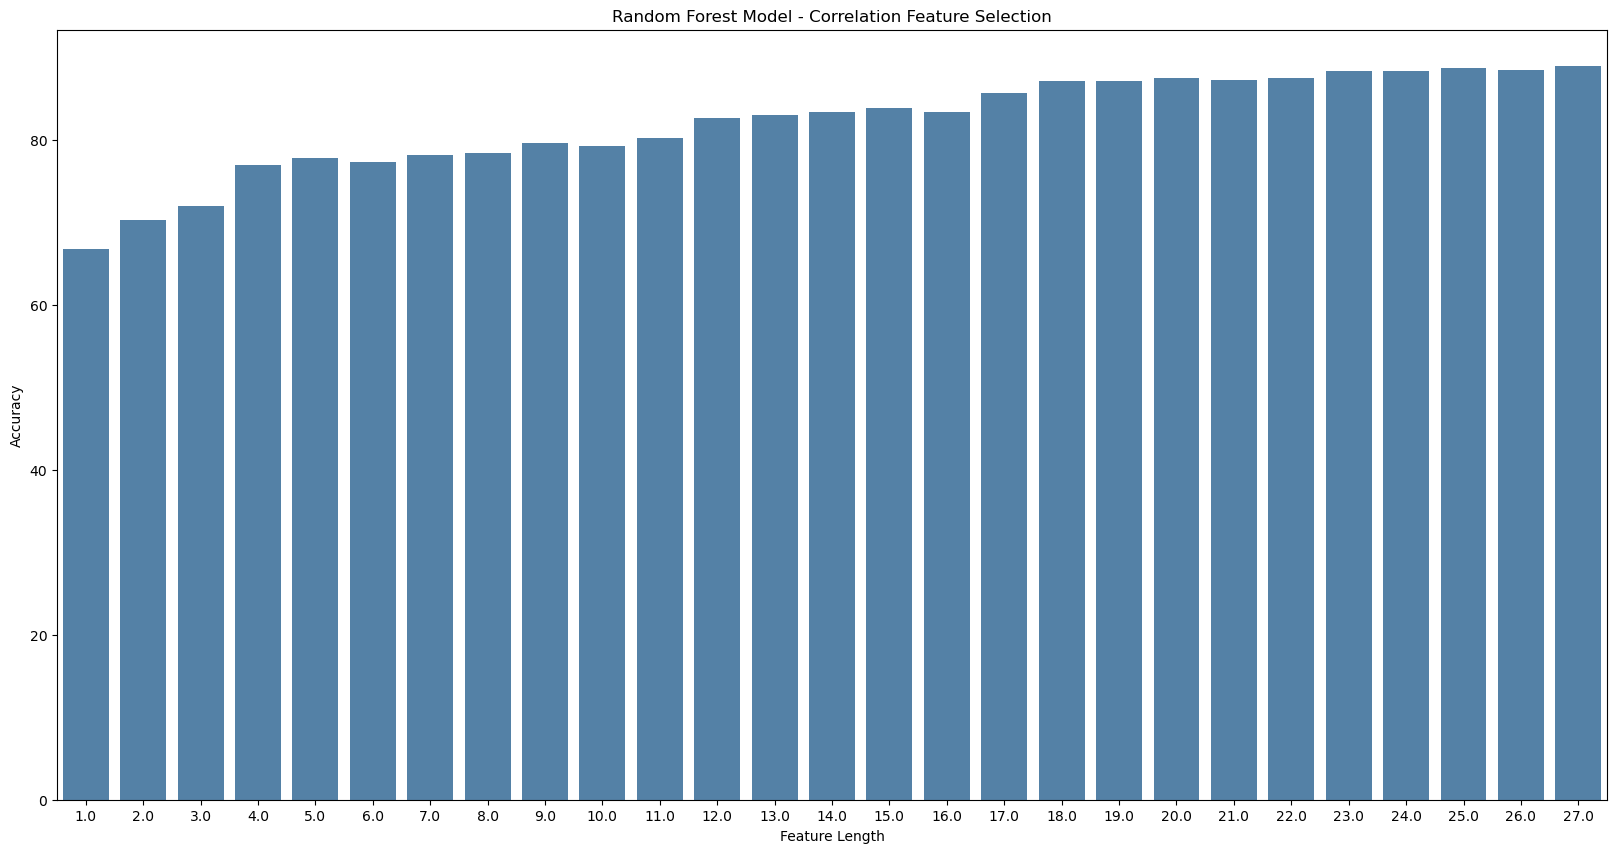

In [46]:
plt.figure(figsize=(20,10))
rf_plot = sns.barplot(x=corr_df['Feature Length'], y=corr_df['Accuracy'], color='steelblue')
rf_plot.set(title='Random Forest Model - Correlation Feature Selection')
plt.show()

In [47]:
corr_df_acc = pd.Series(corr_df['Accuracy'].describe())
corr_df_acc

count    27.000000
mean     82.106861
std       6.059282
min      66.687394
25%      78.273036
50%      83.312606
75%      87.314867
max      88.863765
Name: Accuracy, dtype: float64

## Accuracy Comparison and Visualization

In [48]:
acc_comp_df = pd.DataFrame()
acc_comp_df = pd.concat([chi2_df_acc.to_frame().T, ft_imp_df_acc.to_frame().T, corr_df_acc.to_frame().T])
acc_comp_df.index = ['Chi2 Score', 'Feature Importance', 'Correlation Score']
acc_comp_df

,count,mean,std,min,25%,50%,75%,max
Chi2 Score,27.0,81.222285,5.639490,66.500848,78.072357,81.622386,85.480497,88.485020
Feature Importance,27.0,84.889559,5.875784,66.252120,84.140757,87.863200,88.388920,88.722442
Correlation Score,27.0,82.106861,6.059282,66.687394,78.273036,83.312606,87.314867,88.863765


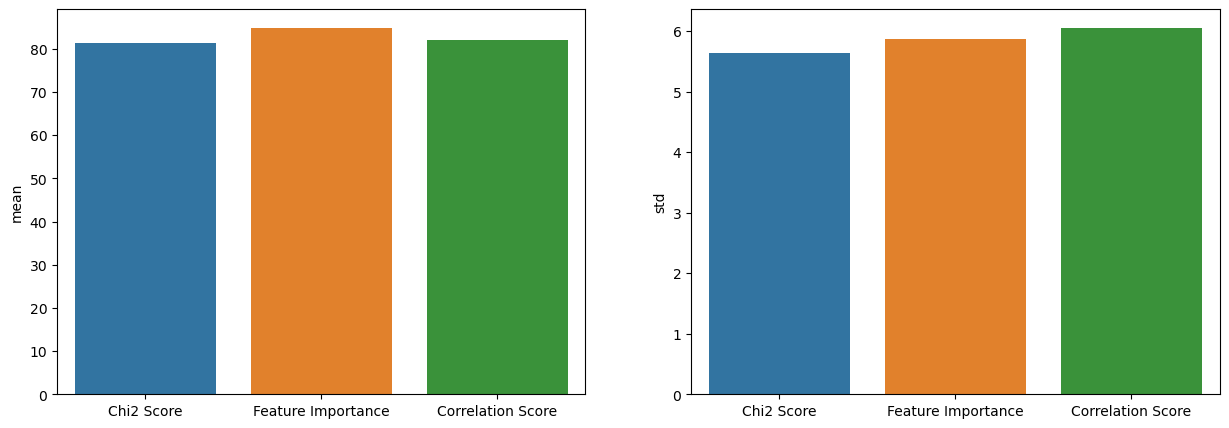

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(ax=axes[0], x=acc_comp_df.index, y=acc_comp_df['mean'])
sns.barplot(ax=axes[1], x=acc_comp_df.index, y=acc_comp_df['std'])
plt.show()

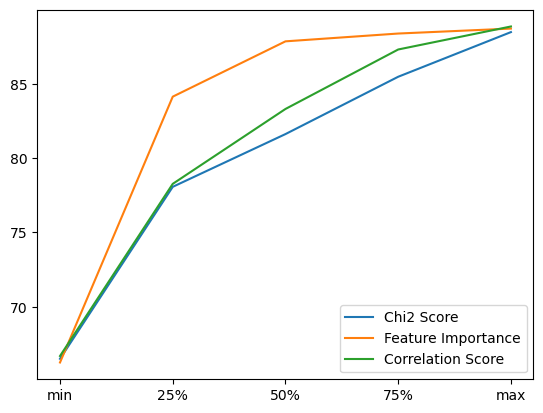

In [50]:
plot_df = acc_comp_df[['min', '25%', '50%', '75%', 'max']]
for row in plot_df.iterrows():
    plt.plot(plot_df.loc[row[0]].index, plot_df.loc[row[0]].values, label=row[0])
plt.legend()
plt.show()

# Final Prediction Model


In [51]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_std, Y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values()

In [52]:
imp_list = feat_importances.nlargest(10).index
X_imp = X[imp_list]

SS = StandardScaler()
X_imp_std = SS.fit_transform(X_imp)

X_train, X_test, Y_train, Y_test = train_test_split(X_imp_std,Y, test_size = 0.2)

rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

RandomForestClassifier()

In [53]:
user_vals = []
for val in imp_list:
    sample = X_imp['country'].sample(5).tolist()
    user_vals.append(int(input('Value for: ' + str(val) + '\nExample Vals =' + str(sample) + '\nENTER: ')))
user_arr = np.array(user_vals).reshape((1,10))

res = rf.predict(user_arr)
print('The result is: ' + str(res)) 

The result is: [1]
